In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
filepath_train = os.getenv('HOME')+'/aiffel/dktc/data/train.csv'

train = pd.read_csv(filepath_train)

train.head()

In [ ]:
len(train)

In [ ]:
train.isnull().sum()

In [ ]:
train['class'].drop_duplicates()

In [ ]:
# 텍스트 클렌징 함수
def clean_text(text):
    # 불필요한 특수 문자, 숫자 제거 (한글, 영문, 공백 제외)
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z\s]", "", text)
    text = re.sub(r"\n", " ", text)
    return text

train['conversation'] = train['conversation'].apply(clean_text)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
#bert 모델, vocab 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

In [ ]:
train.loc[(train['class'] == "협박 대화"), 'label'] = 0  # 협박 대화 => 0
train.loc[(train['class'] == "갈취 대화"), 'label'] = 1  # 갈취 대화 => 1
train.loc[(train['class'] == "직장 내 괴롭힘 대화"), 'label'] = 2  # 직장 내 괴롭힘 대화 => 2
train.loc[(train['class'] == "기타 괴롭힘 대화"), 'label'] = 3  # 기타 괴롭힘 대화 => 3
train.loc[(train['class'] == "일반 대화"), 'label'] = 4  # 일반 대화 => 4

data_list = []
for content, label in zip(train['conversation'], train['label'])  :
    temp = []
    temp.append(content)
    temp.append(str(int(label)))

    data_list.append(temp)

In [ ]:
train.drop(columns = 'idx', inplace = True)

In [ ]:
data_list[0]

In [ ]:
dataset_train, dataset_val = train_test_split(data_list, test_size = 0.2, random_state = 42)

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        
        # 레이블이 없는 경우를 처리
        if label_idx is not None:
            self.labels = [np.int32(i[label_idx]) for i in dataset]
        else:
            self.labels = None

    def __getitem__(self, i):
        if self.labels is not None:
            return self.sentences[i] + (self.labels[i], )
        else:
            return self.sentences[i]

    def __len__(self):
        return len(self.sentences)

In [ ]:
## Setting hyper-parameters
max_len = 300
batch_size = 32
warmup_ratio = 0.2
num_epochs = 25
max_grad_norm = 1
log_interval = 5
learning_rate =  5e-5
dr_rate = 0.2

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
#BERTDataset 클래스 이용, TensorDataset으로 만들어주기
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_val = BERTDataset(dataset_val, 0, 1, tok, max_len, True, False)

In [ ]:
#배치 및 데이터로더 설정
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=4)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=5,
                 dr_rate=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, segment_ids):
        # attention mask는 token_ids에서 패딩(0)이 아닌 부분을 1로 설정
        attention_mask = (token_ids != 0).float()
        
        # BERT 모델에서 pooler 출력 사용
        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))
        
        # 드롭아웃 적용
        if self.dr_rate:
            out = self.dropout(pooler)
        
        return self.classifier(out)

In [19]:
model = BERTClassifier(bertmodel, dr_rate = dr_rate).to(device)

In [20]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [21]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [22]:
# 성능 지표 계산 함수
def calc_metrics(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    pred_labels = max_indices.cpu().numpy()
    true_labels = Y.cpu().numpy()
    
    accuracy = (pred_labels == true_labels).sum() / len(true_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    
    return accuracy, f1, precision, recall

In [23]:
# 로스와 성능 지표 저장 리스트
train_losses = []
val_losses = []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []
train_precisions, val_precisions = [], []
train_recalls = []  
val_recalls = []    

for e in range(num_epochs):
    # 각 에포크 시작 시 성능 지표 초기화
    train_acc = 0.0
    train_f1, train_precision, train_recall = 0.0, 0.0, 0.0  # 성능 지표 초기화
    test_acc, val_f1, val_precision, val_recall = 0.0, 0.0, 0.0, 0.0  # Validation 성능 지표 초기화
    train_loss = 0.0  # 훈련 로스 초기화
    val_loss = 0.0  # Validation 로스 초기화
    
    model.train()
    
    for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)
        
        out = model(token_ids, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        # 성능 지표 계산
        batch_acc, batch_f1, batch_precision, batch_recall = calc_metrics(out, label)
        train_acc += batch_acc
        train_f1 += batch_f1
        train_precision += batch_precision
        train_recall += batch_recall
        train_loss += loss.item()  # 배치의 로스를 누적
        
        if batch_id % log_interval == 0:
            print(f"Epoch {e+1} Batch {batch_id+1}: Loss {loss.data.cpu().numpy()}, Accuracy {train_acc/(batch_id+1)}, F1 {train_f1/(batch_id+1)}, Precision {train_precision/(batch_id+1)}, Recall {train_recall/(batch_id+1)}")
    
    # 에포크가 끝난 후 평균 성능 지표 계산
    train_acc /= len(train_dataloader)
    train_f1 /= len(train_dataloader)
    train_precision /= len(train_dataloader)
    train_recall /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    print(f"Epoch {e+1}: Train Accuracy {train_acc}, F1 {train_f1}, Precision {train_precision}, Recall {train_recall}")
    
    # Validation 성능 계산
    model.eval()
    with torch.no_grad():
        for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            label = label.long().to(device)
            
            out = model(token_ids, segment_ids)
            loss = loss_fn(out, label)
            val_loss += loss.item()  # 배치의 validation 로스를 누적
            batch_acc, batch_f1, batch_precision, batch_recall = calc_metrics(out, label)
            test_acc += batch_acc
            val_f1 += batch_f1
            val_precision += batch_precision
            val_recall += batch_recall
        
        # 에포크가 끝난 후 평균 validation 성능 지표 계산
        test_acc /= len(val_dataloader)
        val_f1 /= len(val_dataloader)
        val_precision /= len(val_dataloader)
        val_recall /= len(val_dataloader)
        val_loss /= len(val_dataloader)

        val_losses.append(val_loss)
        val_accs.append(test_acc)
        val_f1s.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f"Epoch {e+1}: Validation Accuracy {test_acc}, F1 {val_f1}, Precision {val_precision}, Recall {val_recall}")

/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 1: Loss 1.788729190826416, Accuracy 0.09375, F1 0.1166294642857143, Precision 0.18055555555555555, Recall 0.09375


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is 

Epoch 1 Batch 6: Loss 1.833214521408081, Accuracy 0.14583333333333334, F1 0.15817049831296157, Precision 0.19163773148148147, Recall 0.14583333333333334


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is 

Epoch 1 Batch 11: Loss 1.676780104637146, Accuracy 0.14204545454545456, F1 0.15523421681927696, Precision 0.2019593253968254, Recall 0.14204545454545456


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-d

Epoch 1 Batch 16: Loss 1.5814327001571655, Accuracy 0.1640625, F1 0.16095426573490657, Precision 0.19009021553889008, Recall 0.1640625


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 21: Loss 1.476335883140564, Accuracy 0.18601190476190477, F1 0.1756080607046657, Precision 0.2004916616178226, Recall 0.18601190476190477


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 26: Loss 1.5331165790557861, Accuracy 0.2091346153846154, F1 0.1963393208836156, Precision 0.22487515396383204, Recall 0.2091346153846154
Epoch 1 Batch 31: Loss 1.5188238620758057, Accuracy 0.21774193548387097, F1 0.19922272313605952, Precision 0.23385700234404727, Recall 0.21774193548387097


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 36: Loss 1.5244686603546143, Accuracy 0.2230902777777778, F1 0.1995963656255012, Precision 0.23318076524599837, Recall 0.2230902777777778
Epoch 1 Batch 41: Loss 1.4992398023605347, Accuracy 0.22789634146341464, F1 0.19995981808278218, Precision 0.2341307072842729, Recall 0.22789634146341464


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 46: Loss 1.4221783876419067, Accuracy 0.23573369565217392, F1 0.2018910678333124, Precision 0.23603556125865466, Recall 0.23573369565217392


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 51: Loss 1.5039345026016235, Accuracy 0.23897058823529413, F1 0.20491296179497936, Precision 0.24495807098383424, Recall 0.23897058823529413


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 56: Loss 1.4177539348602295, Accuracy 0.24553571428571427, F1 0.21116648657302206, Precision 0.2523145189853034, Recall 0.24553571428571427


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 61: Loss 1.4461779594421387, Accuracy 0.2505122950819672, F1 0.21586326641213674, Precision 0.256305479125476, Recall 0.2505122950819672


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 66: Loss 1.4679336547851562, Accuracy 0.25142045454545453, F1 0.21550140630068032, Precision 0.2645814981490331, Recall 0.25142045454545453


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 71: Loss 1.4117790460586548, Accuracy 0.25616197183098594, F1 0.21953932030871584, Precision 0.2639866738046309, Recall 0.25616197183098594


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 76: Loss 1.4275859594345093, Accuracy 0.25863486842105265, F1 0.22111798245568148, Precision 0.2677587114686327, Recall 0.25863486842105265
Epoch 1 Batch 81: Loss 1.3487380743026733, Accuracy 0.26273148148148145, F1 0.22416263506698442, Precision 0.2729582976698019, Recall 0.26273148148148145


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 86: Loss 1.4068900346755981, Accuracy 0.265625, F1 0.22559506733581045, Precision 0.27585002531841246, Recall 0.265625
Epoch 1 Batch 91: Loss 1.4019354581832886, Accuracy 0.27232142857142855, F1 0.23281195656000997, Precision 0.28591255282086375, Recall 0.27232142857142855


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Batch 96: Loss 1.3611552715301514, Accuracy 0.279296875, F1 0.23982336131042012, Precision 0.2914336006933093, Recall 0.279296875


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Train Accuracy 0.2859848484848485, F1 0.24702385853792677, Precision 0.29934135012081803, Recall 0.2859848484848485


/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

Epoch 1: Validation Accuracy 0.4775, F1 0.4298735808376886, Precision 0.5156633786051839, Recall 0.4775


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2 Batch 1: Loss 1.3081536293029785, Accuracy 0.53125, F1 0.530047545333923, Precision 0.5964218073593073, Recall 0.53125


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 Batch 6: Loss 1.2914553880691528, Accuracy 0.40625, F1 0.3668474521899861, Precision 0.3903350071089042, Recall 0.40625


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 Batch 11: Loss 1.2921977043151855, Accuracy 0.41761363636363635, F1 0.38402653843744633, Precision 0.43914917705156586, Recall 0.41761363636363635


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 Batch 16: Loss 1.208484411239624, Accuracy 0.447265625, F1 0.40452915026433667, Precision 0.4754517340728157, Recall 0.447265625


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 Batch 21: Loss 1.3341095447540283, Accuracy 0.47172619047619047, F1 0.4286562126853673, Precision 0.4915729770673657, Recall 0.47172619047619047
Epoch 2 Batch 26: Loss 1.2134145498275757, Accuracy 0.49278846153846156, F1 0.4559423928307598, Precision 0.5238122786226502, Recall 0.49278846153846156
Epoch 2 Batch 31: Loss 1.132644772529602, Accuracy 0.5080645161290323, F1 0.4738796937118406, Precision 0.5359922949663164, Recall 0.5080645161290323


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 Batch 36: Loss 0.9490540623664856, Accuracy 0.5355902777777778, F1 0.5024649619232363, Precision 0.5613476510631279, Recall 0.5355902777777778
Epoch 2 Batch 41: Loss 1.0247424840927124, Accuracy 0.5434451219512195, F1 0.5133712985816126, Precision 0.5704609473569255, Recall 0.5434451219512195
Epoch 2 Batch 46: Loss 1.0621408224105835, Accuracy 0.5550271739130435, F1 0.5273487645807635, Precision 0.5893496520279967, Recall 0.5550271739130435
Epoch 2 Batch 51: Loss 1.0374038219451904, Accuracy 0.5649509803921569, F1 0.5397787490313847, Precision 0.5982014407336241, Recall 0.5649509803921569


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 Batch 56: Loss 0.9819116592407227, Accuracy 0.5797991071428571, F1 0.5545220289535474, Precision 0.6080495068706694, Recall 0.5797991071428571
Epoch 2 Batch 61: Loss 0.9541418552398682, Accuracy 0.5983606557377049, F1 0.5749997431919758, Precision 0.6280635160181898, Recall 0.5983606557377049
Epoch 2 Batch 66: Loss 0.8934360146522522, Accuracy 0.6074810606060606, F1 0.5847052302677829, Precision 0.6376619576371105, Recall 0.6074810606060606
Epoch 2 Batch 71: Loss 0.7750065326690674, Accuracy 0.6210387323943662, F1 0.5991355493744628, Precision 0.6509037455725496, Recall 0.6210387323943662
Epoch 2 Batch 76: Loss 0.9014706611633301, Accuracy 0.6254111842105263, F1 0.6048582883268717, Precision 0.6582801264106543, Recall 0.6254111842105263
Epoch 2 Batch 81: Loss 0.8361474275588989, Accuracy 0.6331018518518519, F1 0.6132623807601378, Precision 0.6660027576283146, Recall 0.6331018518518519
Epoch 2 Batch 86: Loss 0.9694346189498901, Accuracy 0.637718023255814, F1 0.6189623229356137, 

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2: Validation Accuracy 0.8107954545454545, F1 0.8043678761916077, Precision 0.8415681588148695, Recall 0.8107954545454545


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3 Batch 1: Loss 0.6329599618911743, Accuracy 0.84375, F1 0.8451923076923078, Precision 0.875, Recall 0.84375
Epoch 3 Batch 6: Loss 0.7255569100379944, Accuracy 0.7916666666666666, F1 0.7864897217818413, Precision 0.826018772893773, Recall 0.7916666666666666
Epoch 3 Batch 11: Loss 0.6585771441459656, Accuracy 0.7926136363636364, F1 0.7899084274730925, Precision 0.8287370615495615, Recall 0.7926136363636364
Epoch 3 Batch 16: Loss 0.7136182188987732, Accuracy 0.80078125, F1 0.7982161502903826, Precision 0.8336025844814907, Recall 0.80078125
Epoch 3 Batch 21: Loss 0.8785507082939148, Accuracy 0.8020833333333334, F1 0.8004001193326479, Precision 0.8339378049199476, Recall 0.8020833333333334
Epoch 3 Batch 26: Loss 0.6880728602409363, Accuracy 0.8052884615384616, F1 0.8024385482490051, Precision 0.8363303363303363, Recall 0.8052884615384616
Epoch 3 Batch 31: Loss 0.5236963629722595, Accuracy 0.8084677419354839, F1 0.8060015781763101, Precision 0.8386766431373287, Recall 0.80846774193548

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3: Validation Accuracy 0.8320454545454545, F1 0.8311849026155106, Precision 0.8587185020861493, Recall 0.8320454545454545


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4 Batch 1: Loss 0.41170457005500793, Accuracy 0.8125, F1 0.8110716276477145, Precision 0.8592032967032966, Recall 0.8125
Epoch 4 Batch 6: Loss 0.708535373210907, Accuracy 0.8177083333333334, F1 0.8164264015129289, Precision 0.852043428215303, Recall 0.8177083333333334
Epoch 4 Batch 11: Loss 0.6071757078170776, Accuracy 0.8380681818181818, F1 0.8347481452837411, Precision 0.8704255537707243, Recall 0.8380681818181818
Epoch 4 Batch 16: Loss 0.48091623187065125, Accuracy 0.84765625, F1 0.8447666480850118, Precision 0.8749338579172564, Recall 0.84765625
Epoch 4 Batch 21: Loss 0.6181415319442749, Accuracy 0.8556547619047619, F1 0.8523001964786988, Precision 0.8797374025610633, Recall 0.8556547619047619
Epoch 4 Batch 26: Loss 0.24975155293941498, Accuracy 0.859375, F1 0.8566323155620196, Precision 0.8842225733000973, Recall 0.859375
Epoch 4 Batch 31: Loss 0.36006560921669006, Accuracy 0.8649193548387096, F1 0.8623175839426802, Precision 0.8884557408876966, Recall 0.8649193548387096
Epo

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4: Validation Accuracy 0.8663636363636364, F1 0.866599117537538, Precision 0.8806932442557445, Recall 0.8663636363636364


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5 Batch 1: Loss 0.12045280635356903, Accuracy 0.96875, F1 0.9693480861244019, Precision 0.9739583333333334, Recall 0.96875
Epoch 5 Batch 6: Loss 0.45990774035453796, Accuracy 0.890625, F1 0.885632344474193, Precision 0.908117071007696, Recall 0.890625
Epoch 5 Batch 11: Loss 0.46679410338401794, Accuracy 0.8920454545454546, F1 0.8888844331290606, Precision 0.9063608897415716, Recall 0.8920454545454546
Epoch 5 Batch 16: Loss 0.4291236400604248, Accuracy 0.880859375, F1 0.8778357972080892, Precision 0.8987431567997973, Recall 0.880859375
Epoch 5 Batch 21: Loss 0.40559178590774536, Accuracy 0.8839285714285714, F1 0.8817028666080162, Precision 0.9012373456569884, Recall 0.8839285714285714
Epoch 5 Batch 26: Loss 0.4205057919025421, Accuracy 0.8846153846153846, F1 0.8828751397096247, Precision 0.9014219754604368, Recall 0.8846153846153846
Epoch 5 Batch 31: Loss 0.21785102784633636, Accuracy 0.8961693548387096, F1 0.8945897376807573, Precision 0.9108785032172128, Recall 0.896169354838709

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5 Batch 81: Loss 0.30195799469947815, Accuracy 0.9016203703703703, F1 0.899365683811937, Precision 0.9140200902064323, Recall 0.9016203703703703
Epoch 5 Batch 86: Loss 0.5557935833930969, Accuracy 0.8993459302325582, F1 0.897197329552423, Precision 0.9126725735101455, Recall 0.8993459302325582
Epoch 5 Batch 91: Loss 0.23474843800067902, Accuracy 0.8983516483516484, F1 0.8962002737728072, Precision 0.9124710178024047, Recall 0.8983516483516484
Epoch 5 Batch 96: Loss 0.2998966574668884, Accuracy 0.8990885416666666, F1 0.8969655142966397, Precision 0.9131616873071947, Recall 0.8990885416666666
Epoch 5: Train Accuracy 0.89888468013468, F1 0.8969186921977826, Precision 0.9132979613329989, Recall 0.89888468013468


/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5: Validation Accuracy 0.8707954545454545, F1 0.871045950625885, Precision 0.8876071844821846, Recall 0.8707954545454545


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6 Batch 1: Loss 0.23910416662693024, Accuracy 0.9375, F1 0.9351325757575757, Precision 0.9479166666666667, Recall 0.9375
Epoch 6 Batch 6: Loss 0.5707786679267883, Accuracy 0.890625, F1 0.8889917782419928, Precision 0.90918391504329, Recall 0.890625
Epoch 6 Batch 11: Loss 0.34770649671554565, Accuracy 0.8892045454545454, F1 0.8869421730353225, Precision 0.9030651718861944, Recall 0.8892045454545454
Epoch 6 Batch 16: Loss 0.2894212007522583, Accuracy 0.900390625, F1 0.8986026163463442, Precision 0.912554361870768, Recall 0.900390625
Epoch 6 Batch 21: Loss 0.3355345129966736, Accuracy 0.9002976190476191, F1 0.8979673459487213, Precision 0.9156731826374682, Recall 0.9002976190476191
Epoch 6 Batch 26: Loss 0.22411124408245087, Accuracy 0.9098557692307693, F1 0.9080627823240525, Precision 0.9240226286800804, Recall 0.9098557692307693
Epoch 6 Batch 31: Loss 0.20614729821681976, Accuracy 0.9143145161290323, F1 0.9126726232306103, Precision 0.9273271475388409, Recall 0.9143145161290323
Ep

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6: Validation Accuracy 0.8570454545454546, F1 0.8579938268053644, Precision 0.8735569187756689, Recall 0.8570454545454546


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7 Batch 1: Loss 0.020983470603823662, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 7 Batch 6: Loss 0.3651754856109619, Accuracy 0.9427083333333334, F1 0.9396494873662057, Precision 0.9499276620370369, Recall 0.9427083333333334
Epoch 7 Batch 11: Loss 0.869239091873169, Accuracy 0.9375, F1 0.9354201305811397, Precision 0.9456969246031744, Recall 0.9375
Epoch 7 Batch 16: Loss 0.2627049386501312, Accuracy 0.9375, F1 0.9361022596490298, Precision 0.9465950119758714, Recall 0.9375
Epoch 7 Batch 21: Loss 0.32767966389656067, Accuracy 0.9419642857142857, F1 0.9409222805340427, Precision 0.9502142615981901, Recall 0.9419642857142857
Epoch 7 Batch 26: Loss 0.3269665241241455, Accuracy 0.9435096153846154, F1 0.9427225046869256, Precision 0.9521094890686237, Recall 0.9435096153846154
Epoch 7 Batch 31: Loss 0.2632889449596405, Accuracy 0.9455645161290323, F1 0.9448463198623948, Precision 0.9534700346696315, Recall 0.9455645161290323
Epoch 7 Batch 36: Loss 0.12414898723363876, Accurac

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7: Validation Accuracy 0.8545454545454545, F1 0.8540632496923005, Precision 0.8820365537240538, Recall 0.8545454545454545


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 8 Batch 1: Loss 0.15145520865917206, Accuracy 0.96875, F1 0.9693480861244019, Precision 0.9739583333333334, Recall 0.96875
Epoch 8 Batch 6: Loss 0.26479363441467285, Accuracy 0.9583333333333334, F1 0.95761006906034, Precision 0.963518931878307, Recall 0.9583333333333334
Epoch 8 Batch 11: Loss 0.1833675354719162, Accuracy 0.9630681818181818, F1 0.9626079062990538, Precision 0.9671808384166337, Recall 0.9630681818181818
Epoch 8 Batch 16: Loss 0.255694717168808, Accuracy 0.95703125, F1 0.9567576095665119, Precision 0.9629289709856115, Recall 0.95703125
Epoch 8 Batch 21: Loss 0.5087564587593079, Accuracy 0.9553571428571429, F1 0.9551191134152445, Precision 0.9614757927257926, Recall 0.9553571428571429
Epoch 8 Batch 26: Loss 0.39861515164375305, Accuracy 0.9495192307692307, F1 0.9493425826779937, Precision 0.9570720612186956, Recall 0.9495192307692307
Epoch 8 Batch 31: Loss 0.14297525584697723, Accuracy 0.9516129032258065, F1 0.9514703444410137, Precision 0.9588763331202846, Recall 0.

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8: Validation Accuracy 0.8409090909090909, F1 0.8406017449120432, Precision 0.87457376998002, Recall 0.8409090909090909


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 9 Batch 1: Loss 0.17282234132289886, Accuracy 0.96875, F1 0.968969298245614, Precision 0.97265625, Recall 0.96875
Epoch 9 Batch 6: Loss 0.0868772491812706, Accuracy 0.921875, F1 0.9203940165573176, Precision 0.9356515879953381, Recall 0.921875
Epoch 9 Batch 11: Loss 0.41719523072242737, Accuracy 0.9318181818181818, F1 0.9310542977638854, Precision 0.9431399566342747, Recall 0.9318181818181818
Epoch 9 Batch 16: Loss 0.1669388860464096, Accuracy 0.943359375, F1 0.9427855954252062, Precision 0.9524104638850732, Recall 0.943359375
Epoch 9 Batch 21: Loss 0.024150928482413292, Accuracy 0.9538690476190477, F1 0.9533996723750902, Precision 0.9611129817603031, Recall 0.9538690476190477
Epoch 9 Batch 26: Loss 0.04599027335643768, Accuracy 0.9543269230769231, F1 0.9539151459222767, Precision 0.9618394993094511, Recall 0.9543269230769231
Epoch 9 Batch 31: Loss 0.021413708105683327, Accuracy 0.9586693548387096, F1 0.9582928475481269, Precision 0.9653178838410692, Recall 0.9586693548387096
Epo

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9: Validation Accuracy 0.8664772727272727, F1 0.8657052987980323, Precision 0.8818425740925742, Recall 0.8664772727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 10 Batch 1: Loss 0.030765004456043243, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 10 Batch 6: Loss 0.42895588278770447, Accuracy 0.96875, F1 0.9684075075302129, Precision 0.9707509793447294, Recall 0.96875
Epoch 10 Batch 11: Loss 0.20071198046207428, Accuracy 0.9715909090909091, F1 0.9715346664824697, Precision 0.9738773379398379, Recall 0.9715909090909091
Epoch 10 Batch 16: Loss 0.07513173669576645, Accuracy 0.9765625, F1 0.9765177863800725, Precision 0.9784924927503053, Recall 0.9765625
Epoch 10 Batch 21: Loss 0.016542350873351097, Accuracy 0.9806547619047619, F1 0.9805884845311788, Precision 0.9822605139569425, Recall 0.9806547619047619
Epoch 10 Batch 26: Loss 0.051552142947912216, Accuracy 0.9783653846153846, F1 0.9784642409355017, Precision 0.9809978082814619, Recall 0.9783653846153846
Epoch 10 Batch 31: Loss 0.011473097838461399, Accuracy 0.9818548387096774, F1 0.9819377504620337, Precision 0.9840626779134842, Recall 0.9818548387096774
Epoch 10 Batch 36: Loss 0.0

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10: Validation Accuracy 0.8989772727272727, F1 0.8986135708099304, Precision 0.9108389874014873, Recall 0.8989772727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 11 Batch 1: Loss 0.04082922264933586, Accuracy 0.96875, F1 0.9693480861244019, Precision 0.9739583333333334, Recall 0.96875
Epoch 11 Batch 6: Loss 0.2875714898109436, Accuracy 0.984375, F1 0.9839857761676046, Precision 0.9866319444444445, Recall 0.984375
Epoch 11 Batch 11: Loss 0.03154218941926956, Accuracy 0.9772727272727273, F1 0.9773824856031794, Precision 0.9802624458874458, Recall 0.9772727272727273
Epoch 11 Batch 16: Loss 0.06965401023626328, Accuracy 0.9765625, F1 0.9764696059263288, Precision 0.9795805431547618, Recall 0.9765625
Epoch 11 Batch 21: Loss 0.010013304650783539, Accuracy 0.9806547619047619, F1 0.9805517756140406, Precision 0.9830895047412904, Recall 0.9806547619047619
Epoch 11 Batch 26: Loss 0.013908542692661285, Accuracy 0.9795673076923077, F1 0.9796273220776637, Precision 0.9826689803252301, Recall 0.9795673076923077
Epoch 11 Batch 31: Loss 0.1868373602628708, Accuracy 0.9788306451612904, F1 0.9787867203998577, Precision 0.9819147558310864, Recall 0.97883064

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11: Validation Accuracy 0.8914772727272726, F1 0.8917370403700013, Precision 0.9022816558441557, Recall 0.8914772727272726


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 12 Batch 1: Loss 0.010579538531601429, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 12 Batch 6: Loss 0.15283991396427155, Accuracy 0.9895833333333334, F1 0.989573397952021, Precision 0.9906684027777777, Recall 0.9895833333333334
Epoch 12 Batch 11: Loss 0.032635271549224854, Accuracy 0.9857954545454546, F1 0.9857216420205481, Precision 0.9874921085858585, Recall 0.9857954545454546
Epoch 12 Batch 16: Loss 0.018450558185577393, Accuracy 0.98828125, F1 0.9882305038891268, Precision 0.9896104600694443, Recall 0.98828125
Epoch 12 Batch 21: Loss 0.07079626619815826, Accuracy 0.9880952380952381, F1 0.9880212835955553, Precision 0.9893672588985089, Recall 0.9880952380952381
Epoch 12 Batch 26: Loss 0.0650877133011818, Accuracy 0.9855769230769231, F1 0.9856550098767756, Precision 0.9877394740675989, Recall 0.9855769230769231
Epoch 12 Batch 31: Loss 0.24103955924510956, Accuracy 0.9828629032258065, F1 0.9828576307492832, Precision 0.9854991446725316, Recall 0.9828629032258065
Epoch 

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12: Validation Accuracy 0.9002272727272727, F1 0.9003100643377092, Precision 0.909628427128427, Recall 0.9002272727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 13 Batch 1: Loss 0.01724999211728573, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 13 Batch 6: Loss 0.009657745249569416, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 13 Batch 11: Loss 0.006326827220618725, Accuracy 0.9971590909090909, F1 0.9971678862932734, Precision 0.9974747474747474, Recall 0.9971590909090909
Epoch 13 Batch 16: Loss 0.2057117521762848, Accuracy 0.982421875, F1 0.9826958510845006, Precision 0.9850694444444444, Recall 0.982421875
Epoch 13 Batch 21: Loss 0.004564217757433653, Accuracy 0.9851190476190477, F1 0.9852955814488382, Precision 0.9872715247715247, Recall 0.9851190476190477
Epoch 13 Batch 26: Loss 0.005042287986725569, Accuracy 0.984375, F1 0.9845557413045256, Precision 0.9868346930846931, Recall 0.984375
Epoch 13 Batch 31: Loss 0.005156075116246939, Accuracy 0.9858870967741935, F1 0.9860330388351501, Precision 0.9880417073965462, Recall 0.9858870967741935
Epoch 13 Batch 36: Loss 0.15004947781562805, Accuracy 0.9869791666666666, F1 0.98

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13: Validation Accuracy 0.8745454545454545, F1 0.8751268076086616, Precision 0.8922559072871573, Recall 0.8745454545454545


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 14 Batch 1: Loss 0.003301713615655899, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 14 Batch 6: Loss 0.004743770696222782, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 14 Batch 11: Loss 0.029932944104075432, Accuracy 0.9943181818181818, F1 0.9943428926594561, Precision 0.9949494949494948, Recall 0.9943181818181818
Epoch 14 Batch 16: Loss 0.005829473491758108, Accuracy 0.9921875, F1 0.9921581695334156, Precision 0.9929470486111109, Recall 0.9921875
Epoch 14 Batch 21: Loss 0.037990931421518326, Accuracy 0.9910714285714286, F1 0.990966549634439, Precision 0.9919094215969215, Recall 0.9910714285714286
Epoch 14 Batch 26: Loss 0.2752397656440735, Accuracy 0.9891826923076923, F1 0.9891252615532853, Precision 0.9903670114607614, Recall 0.9891826923076923
Epoch 14 Batch 31: Loss 0.004985098727047443, Accuracy 0.9899193548387096, F1 0.9898935885428988, Precision 0.9911142676767677, Recall 0.9899193548387096
Epoch 14 Batch 36: Loss 0.003488728776574135, Accuracy 0.99131944

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14: Validation Accuracy 0.9027272727272727, F1 0.9037855233372007, Precision 0.9160473033910534, Recall 0.9027272727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 15 Batch 1: Loss 0.003865945851430297, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 15 Batch 6: Loss 0.003935820423066616, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 15 Batch 11: Loss 0.0039923121221363544, Accuracy 0.9971590909090909, F1 0.9971678862932734, Precision 0.9974747474747474, Recall 0.9971590909090909
Epoch 15 Batch 16: Loss 0.19322463870048523, Accuracy 0.9921875, F1 0.992197516025641, Precision 0.9930416046626984, Recall 0.9921875
Epoch 15 Batch 21: Loss 0.006538318004459143, Accuracy 0.9925595238095238, F1 0.9925349452135166, Precision 0.9933455516044802, Recall 0.9925595238095238
Epoch 15 Batch 26: Loss 0.0032861630897969007, Accuracy 0.9927884615384616, F1 0.9927716219340712, Precision 0.9935435224497725, Recall 0.9927884615384616
Epoch 15 Batch 31: Loss 0.004174571949988604, Accuracy 0.9939516129032258, F1 0.9939374893640598, Precision 0.9945848897965834, Recall 0.9939516129032258
Epoch 15 Batch 36: Loss 0.002271883189678192, Accuracy 0.99392

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15: Validation Accuracy 0.8852272727272726, F1 0.8865641575209652, Precision 0.9002615891053389, Recall 0.8852272727272726


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 16 Batch 1: Loss 0.004289783071726561, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 16 Batch 6: Loss 0.006229565013200045, Accuracy 0.9947916666666666, F1 0.9949151844532279, Precision 0.9956597222222223, Recall 0.9947916666666666
Epoch 16 Batch 11: Loss 0.005795883946120739, Accuracy 0.9971590909090909, F1 0.9972264642472152, Precision 0.9976325757575758, Recall 0.9971590909090909
Epoch 16 Batch 16: Loss 0.005176091101020575, Accuracy 0.99609375, F1 0.9961400691699605, Precision 0.99658203125, Recall 0.99609375
Epoch 16 Batch 21: Loss 0.0038313057739287615, Accuracy 0.9940476190476191, F1 0.994103610043051, Precision 0.9948525432900434, Recall 0.9940476190476191
Epoch 16 Batch 26: Loss 0.0026343390345573425, Accuracy 0.9939903846153846, F1 0.9940737643998514, Precision 0.9948809003496505, Recall 0.9939903846153846
Epoch 16 Batch 31: Loss 0.0038606906309723854, Accuracy 0.9939516129032258, F1 0.994033232039894, Precision 0.994824505131965, Recall 0.9939516129032258
Epoch

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16: Validation Accuracy 0.9002272727272727, F1 0.9009980498923162, Precision 0.9124758748196246, Recall 0.9002272727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 17 Batch 1: Loss 0.0022910486441105604, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 17 Batch 6: Loss 0.003144658636301756, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 17 Batch 11: Loss 0.0030692436266690493, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 17 Batch 16: Loss 0.0042020175606012344, Accuracy 0.998046875, F1 0.998046875, Precision 0.9982096354166666, Recall 0.998046875
Epoch 17 Batch 21: Loss 0.003982301335781813, Accuracy 0.9985119047619048, F1 0.9985119047619048, Precision 0.9986359126984126, Recall 0.9985119047619048
Epoch 17 Batch 26: Loss 0.0022456550505012274, Accuracy 0.9987980769230769, F1 0.9987980769230769, Precision 0.9988982371794871, Recall 0.9987980769230769
Epoch 17 Batch 31: Loss 0.0040951082482934, Accuracy 0.998991935483871, F1 0.998991935483871, Precision 0.999075940860215, Recall 0.998991935483871
Epoch 17 Batch 36: Loss 0.0016115157632157207, Accuracy 0.9991319444444444, F1 0.9991319444444444, Precision 0.9992042824074073

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17: Validation Accuracy 0.8914772727272726, F1 0.892687380046148, Precision 0.905941964285714, Recall 0.8914772727272726


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 18 Batch 1: Loss 0.002050694078207016, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 6: Loss 0.002812681719660759, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 11: Loss 0.0019519911147654057, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 18 Batch 16: Loss 0.00880537647753954, Accuracy 0.998046875, F1 0.998046875, Precision 0.9982096354166666, Recall 0.998046875
Epoch 18 Batch 21: Loss 0.0023653784301131964, Accuracy 0.9985119047619048, F1 0.9985119047619048, Precision 0.9986359126984126, Recall 0.9985119047619048
Epoch 18 Batch 26: Loss 0.0014568825718015432, Accuracy 0.9987980769230769, F1 0.9987980769230769, Precision 0.9988982371794871, Recall 0.9987980769230769
Epoch 18 Batch 31: Loss 0.0024620292242616415, Accuracy 0.998991935483871, F1 0.998991935483871, Precision 0.999075940860215, Recall 0.998991935483871
Epoch 18 Batch 36: Loss 0.0012163373176008463, Accuracy 0.9991319444444444, F1 0.9991319444444444, Precision 0.999204282407407

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18: Validation Accuracy 0.9002272727272727, F1 0.9001630208760558, Precision 0.9127204982517482, Recall 0.9002272727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 19 Batch 1: Loss 0.0013395954156294465, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 19 Batch 6: Loss 0.002924536354839802, Accuracy 0.9947916666666666, F1 0.9948752228163992, Precision 0.9956597222222223, Recall 0.9947916666666666
Epoch 19 Batch 11: Loss 0.001385713228955865, Accuracy 0.9971590909090909, F1 0.9972046669907632, Precision 0.9976325757575758, Recall 0.9971590909090909
Epoch 19 Batch 16: Loss 0.0016443004133179784, Accuracy 0.998046875, F1 0.9980782085561497, Precision 0.9983723958333334, Recall 0.998046875
Epoch 19 Batch 21: Loss 0.001592018874362111, Accuracy 0.9985119047619048, F1 0.9985357779475427, Precision 0.9987599206349207, Recall 0.9985119047619048
Epoch 19 Batch 26: Loss 0.001353435916826129, Accuracy 0.9987980769230769, F1 0.9988173591114767, Precision 0.9989983974358976, Recall 0.9987980769230769
Epoch 19 Batch 31: Loss 0.0016257576644420624, Accuracy 0.998991935483871, F1 0.9990081076418837, Precision 0.9991599462365592, Recall 0.9989919354838

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19: Validation Accuracy 0.8977272727272727, F1 0.8974104202503677, Precision 0.9099233856421357, Recall 0.8977272727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 20 Batch 1: Loss 0.0010945781832560897, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 6: Loss 0.0013532205484807491, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 11: Loss 0.001206864370033145, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 16: Loss 0.0013440247857943177, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 21: Loss 0.001470243907533586, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 26: Loss 0.0011410514125600457, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 31: Loss 0.0014030818128958344, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 36: Loss 0.0009322051773779094, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 41: Loss 0.0013906769454479218, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 46: Loss 0.0010534586617723107, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 20 Batch 51: Loss 0.001083556329831481, Accuracy

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20: Validation Accuracy 0.9039772727272727, F1 0.9046722062053414, Precision 0.9153603896103896, Recall 0.9039772727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 21 Batch 1: Loss 0.0009445616160519421, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 6: Loss 0.0011042949045076966, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 11: Loss 0.0009658330236561596, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 16: Loss 0.0012815407244488597, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 21: Loss 0.0011106374440714717, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 26: Loss 0.0008795551839284599, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 31: Loss 0.0011528681498020887, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 36: Loss 0.0007973285391926765, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 41: Loss 0.0012488981010392308, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 46: Loss 0.0008649207884445786, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 21 Batch 51: Loss 0.0008535381639376283, Accur

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21: Validation Accuracy 0.9052272727272727, F1 0.905650195574466, Precision 0.9156863726551225, Recall 0.9052272727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 22 Batch 1: Loss 0.0008361065411008894, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 6: Loss 0.000941749953199178, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 11: Loss 0.0009071500971913338, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 16: Loss 0.0009938015136867762, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 21: Loss 0.0009935982525348663, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 26: Loss 0.0009741198155097663, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 31: Loss 0.0010639851680025458, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 36: Loss 0.0007513459422625601, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 41: Loss 0.0011587191838771105, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 46: Loss 0.0008705466170795262, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 22 Batch 51: Loss 0.0008576951222494245, Accura

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22: Validation Accuracy 0.9052272727272727, F1 0.905894886555999, Precision 0.9163079906204905, Recall 0.9052272727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 23 Batch 1: Loss 0.0008871220634318888, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 6: Loss 0.0008351542637683451, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 11: Loss 0.0008042409899644554, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 16: Loss 0.0009406408644281328, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 21: Loss 0.0010127625428140163, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 26: Loss 0.0009044571779668331, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 31: Loss 0.0010466431267559528, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 36: Loss 0.0007638632087036967, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 41: Loss 0.0011696292785927653, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 46: Loss 0.0008332716533914208, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 23 Batch 51: Loss 0.0008644754416309297, Accur

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23: Validation Accuracy 0.9039772727272727, F1 0.90481978774177, Precision 0.9158318001443001, Recall 0.9039772727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 24 Batch 1: Loss 0.000787534227129072, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 6: Loss 0.0008654618286527693, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 11: Loss 0.0008145891479216516, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 16: Loss 0.0009333549533039331, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 21: Loss 0.000951574242208153, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 26: Loss 0.0008783271186985075, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 31: Loss 0.001008221646770835, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 36: Loss 0.0007019574986770749, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 41: Loss 0.0011274628341197968, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 46: Loss 0.0008253023843280971, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 24 Batch 51: Loss 0.0008483109995722771, Accuracy

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24: Validation Accuracy 0.9052272727272727, F1 0.905894886555999, Precision 0.9163079906204905, Recall 0.9052272727272727


/tmp/ipykernel_238/3821735571.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 25 Batch 1: Loss 0.0008073569042608142, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 6: Loss 0.0008758591138757765, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 11: Loss 0.0007990165613591671, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 16: Loss 0.0008825630648061633, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 21: Loss 0.0009543788037262857, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 26: Loss 0.0008374929893761873, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 31: Loss 0.0010195458307862282, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 36: Loss 0.0007450596895068884, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 41: Loss 0.0011186370393261313, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 46: Loss 0.0008506944868713617, Accuracy 1.0, F1 1.0, Precision 1.0, Recall 1.0
Epoch 25 Batch 51: Loss 0.0007864706567488611, Accur

/tmp/ipykernel_238/3821735571.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, _, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25: Validation Accuracy 0.9052272727272727, F1 0.905894886555999, Precision 0.9163079906204905, Recall 0.9052272727272727


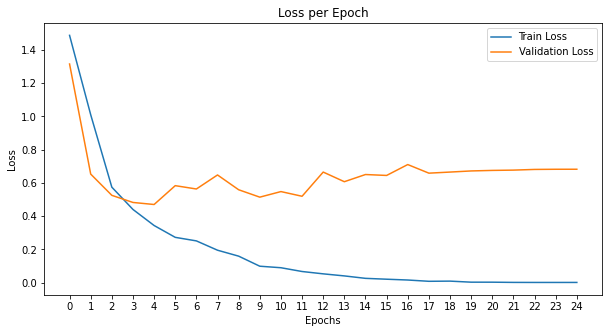

In [24]:
# Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.xticks(range(len(train_losses)))  
plt.show()

In [25]:
filepath_test = os.getenv('HOME')+'/aiffel/dktc/data/test.json'

test = pd.read_json(filepath_test)

test.head().T

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...
t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


In [26]:
# 각 열에 있는 'text' 데이터를 추출하여 하나의 리스트로 만듭니다.
test_list = []

for column in test.columns:
    conversation = test[column]['text']
    test_list.append([conversation])  # 각 대화를 리스트에 추가

# 텍스트 클렌징 함수 (train에서 사용한 것과 동일하게 적용)
def clean_text(text):
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z\s]", "", text)
    text = re.sub(r"\n", " ", text)
    return text

# 전처리 적용
test_list = [[clean_text(conversation[0])] for conversation in test_list]

# 토큰화 및 데이터셋 변환 (BERTDataset 클래스 및 토크나이저는 이미 정의되어 있다고 가정)
data_test = BERTDataset(test_list, 0, None, tok, max_len, True, False)

# 테스트 데이터 로더 생성
test_dataloader = DataLoader(data_test, batch_size=batch_size, num_workers=4)

In [27]:
# 모델 예측
model.eval()
predictions = []

with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        
        # 모델 예측
        out = model(token_ids, segment_ids)
        pred = torch.argmax(out, dim=1).cpu().numpy()  # 가장 높은 확률의 클래스를 예측
        predictions.extend(pred)

# 숫자 레이블을 클래스명으로 변환하는 매핑
label_mapping = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4"
}

# 예측된 숫자 레이블을 클래스명으로 변환
predicted_classes = [label_mapping[pred] for pred in predictions]

/tmp/ipykernel_238/3595121026.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/16 [00:00<?, ?it/s]

In [28]:
filepath_sub = os.getenv('HOME')+'/aiffel/dktc/data/submission.csv'

sub = pd.read_csv(filepath_sub)

sub.head()

,file_name,class
0,t_000,NaN
1,t_001,NaN
2,t_002,NaN
3,t_004,NaN
4,t_005,NaN


In [29]:
# 예측 결과를 DataFrame으로 변환
submission = pd.DataFrame({
    'idx': test.columns,  # 각 대화에 해당하는 열 이름
    'target': predicted_classes  # 예측된 클래스명
})

In [30]:
# 제출 파일로 저장
submission.to_csv('./LJ300.csv', index=False)